In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
import os
from PIL import Image
import random
import time
import albumentations as A
import cv2
import shutil


2025-04-21 21:27:28.631326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745260048.692783  450134 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745260048.710403  450134 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 21:27:28.851372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BCI_Dataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        set_type: str,
        transforms=None,
        wanted_counts: tuple = (),
        wanted_classes: tuple = (),
        is_augmentation_active: bool = False,
    ):
        self.transforms = transforms
        self.image_paths = []
        self.labels = []

        transform_alb = A.Compose(
            [
                A.RandomCrop(width=700, height=700),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=90, p=0.5),  # Sadece döndürme
                A.Affine(
                    scale=(0.9, 1.1),  # Ölçeklendirme
                    translate_percent=(0.1, 0.1),  # Kaydırma
                    rotate=(-10, 10),  # Döndürme
                    p=0.5,  # Uygulama olasılığı
                ),
            ]
        )

        class_names = {"0": "0", "1+": "1", "2+": "2", "3+": "3"}

        for f in os.listdir(root_dir):
            if f.endswith(("png", "jpg", "jpeg")):
                class_name = f.split("_")[2].split(".")[0]
                # print(f"class name: {class_name} file name: {f} path: {os.path.join(root_dir, f)}")
                self.image_paths.append(os.path.join(root_dir, f))
                self.labels.append(class_names[class_name])

        if set_type != "test":
            indexes = []
            for c in class_names.values():
                l = [i for i, x in enumerate(self.labels) if x == c]
                t_size = int(len(l) * 0.8)
                if set_type == "train":
                    indexes.extend([i for i in l[:t_size]])
                elif set_type == "val":
                    indexes.extend([i for i in l[t_size:]])
            random.shuffle(indexes)
            self.image_paths = [self.image_paths[i] for i in indexes]
            self.labels = [self.labels[i] for i in indexes]

        if is_augmentation_active and set_type == "train":
            if os.path.exists(os.path.join(root_dir, "ek_veri")):
                shutil.rmtree(os.path.join(root_dir, "ek_veri"))
            os.makedirs(os.path.join(root_dir, "ek_veri"))
            for i, class_name in enumerate(wanted_classes):  # wanted_classes içinde gez
                filtered_indices = [
                    j for j, x in enumerate(self.labels) if x == class_name
                ]  # Sınıf adıyla karşılaştır
                k = (
                    len(filtered_indices)
                    if len(filtered_indices) > wanted_counts[i]
                    else wanted_counts[i] - len(filtered_indices)
                )
                rnd_images_idx = random.choices(filtered_indices, k=k)
                for j in rnd_images_idx:
                    img = cv2.imread(self.image_paths[j])
                    transformed = transform_alb(image=img)
                    transformed_image = transformed["image"]
                    lb = self.image_paths[j].split("/")[-1]
                    new_image_path = os.path.join(root_dir, "ek_veri", f"{j}_{lb}.png")
                    cv2.imwrite(new_image_path, transformed_image)
                    self.image_paths.append(new_image_path)
                    self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(int(label), dtype=torch.long)

**num_workers**=12: 12 çekirdekli CPU'nuzla veri yüklemeyi paralelleştirerek potansiyel olarak eğitimi hızlandırır. 

**pin_memory**=True: GPU kullanırken CPU'dan GPU'ya veri transferini hızlandırır.

**pin_memory**=True: Veriyi CPU'da hazırlar, GPU'ya transferi hızlandırmak için özel bir bellek alanına koyar. Veri hala CPU'dadır.
**.to(device)**: Veriyi CPU'dan GPU'ya fiilen taşır.


In [ ]:
data_transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.RandomAdjustSharpness(sharpness_factor=1, p=1),
        transforms.ToTensor(),
    ]
)
tv_transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
)
p = "BCI_dataset/"

train_dataset = BCI_Dataset(
    p + "train/",
    "train",
    transforms=data_transform,
    wanted_counts=(1600, 1400, 1400, 1400),
    wanted_classes=("0", "1", "2", "3"),
    is_augmentation_active=True,
)
val_dataset = BCI_Dataset(p + "train/", "val", transforms=tv_transform)
test_dataset = BCI_Dataset(p + "test/", "test", transforms=tv_transform)

In [4]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True
)
valid_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True
)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

print(
    f"train dataset size: {dataset_sizes['train']} val dataset size: {dataset_sizes['val']}"
)

data_loader = {"train": train_loader, "val": valid_loader, "test": test_loader}

train dataset size: 5800 val dataset size: 781


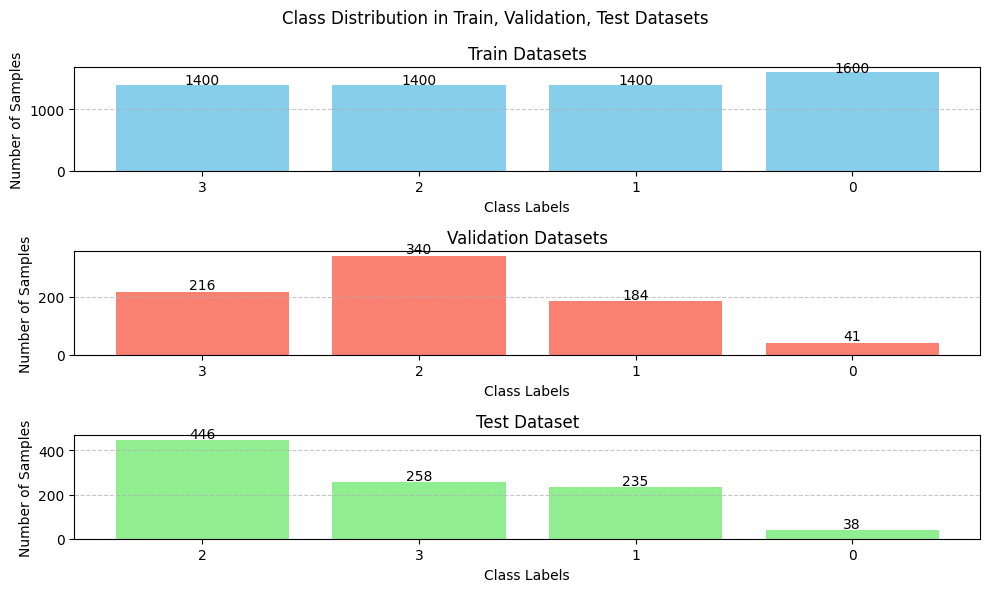

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all datasets
train_labels_combined = train_dataset.labels
valid_labels_combined = val_dataset.labels

# Count the number of samples in each class
train_class_counts = Counter(train_labels_combined)
valid_class_counts = Counter(valid_labels_combined)
test_class_counts = Counter(test_dataset.labels)


fig, ax = plt.subplots(3, 1, figsize=(10, 6))
fig.suptitle("Class Distribution in Train, Validation, Test Datasets")
colors = ["skyblue", "salmon", "lightgreen"]
titles = ["Train Datasets", "Validation Datasets", "Test Dataset"]
for i, counts in enumerate([train_class_counts, valid_class_counts, test_class_counts]):
    ax[i].bar(counts.keys(), counts.values(), color=colors[i])
    for j, count in enumerate(counts.values()):
        ax[i].text(j, count + 10, str(count), ha="center", fontsize=10)
    ax[i].set_xlabel("Class Labels")
    ax[i].set_ylabel("Number of Samples")
    ax[i].set_title(titles[i])
    ax[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
class BCI_Cnn1(nn.Module):
    def __init__(self):
        super(BCI_Cnn1, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # -2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) # -2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # -2
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # -2

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 32 * 32, 64)  # Adjusted for 224x224 input size
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 4)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))  # Updated to conv4

        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
class BCI_Cnn(nn.Module):
    def __init__(self):
        super(BCI_Cnn, self).__init__()
        kernel_size = 5
        self.futures = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #
            nn.Conv2d(8, 16, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 30 * 30, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.28),
            #
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.28),
            #
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.28),
            #
            nn.Linear(256, 4),
        )

    def forward(self, x):
        x = self.futures(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
from math import ceil

kernel_size = 5
kernel_size -= 1

input_size = 512
(
    ceil(
        (
            ceil(
                (
                    ceil(((ceil(input_size - kernel_size) / 2) - kernel_size) / 2)
                    - kernel_size
                )
                / 2
            )
            - kernel_size
        )
        / 2
    )
    + 1
)

30

İşlevi şudur:

1. optimizer: Zamanlayıcının hangi optimizasyon algoritmasının (bu durumda optimizer değişkeni ile tanımlanan, muhtemelen Adam) öğrenme oranını ayarlayacağını belirtir.
2. "min": Zamanlayıcının hangi metriği izleyeceğini ve ne zaman harekete geçeceğini belirler. "min" modu, izlenen metrik (genellikle doğrulama kaybı - validation loss) azalmayı durdurduğunda öğrenme oranını düşürmesi gerektiğini söyler. Eğer doğruluk gibi artması beklenen bir metrik izlenseydi "max" kullanılabilirdi.
3. patience=3: Zamanlayıcının, öğrenme oranını düşürmeden önce metriğin iyileşmesi için kaç epoch (döngü) beklemesi gerektiğini belirtir. Yani, doğrulama kaybı 3 epoch boyunca üst üste azalmazsa (veya aynı kalırsa/artarsa), öğrenme oranı düşürülür.
4. factor=0.5: Öğrenme oranı düşürüldüğünde, mevcut öğrenme oranının hangi çarpanla çarpılacağını belirtir. Burada 0.5 olduğu için, öğrenme oranı yarıya indirilecektir (new_lr = old_lr * 0.5).
5. verbose=True: Öğrenme oranı her düşürüldüğünde konsola bir bilgilendirme mesajı yazdırılmasını sağlar.


In [ ]:
NUM_EPOCHS = 200
LEARNING_RATE = 0.0015
L2_REG = 1e-5

experiment_name = "BCI_CNN_kontrast_x"
experiment_num = 24
model_extension =f"{experiment_num}.pth"

log_dir = f"runs/{experiment_name}_{experiment_num}"
writer = SummaryWriter(log_dir)
since = time.time()

model = BCI_Cnn()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# CrossEntropyLoss'u sınıf ağırlıklarıyla kullanma
# class_counts = [train_class_counts["0"], train_class_counts["1"], 
#                 train_class_counts["2"], train_class_counts["3"]]
# weights = torch.tensor([1.0 / (count + 1e-8) for count in class_counts], dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=L2_REG)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=5, factor=0.2
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

train_losses = []
val_losses = []
val_accuracies = []
lr_rates = []


In [7]:
# https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False
    
    def __call__(self, val_loss, model: nn.Module):
        print(f"early stop counter: {self.counter}")
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), f"{log_dir}/best_model{model_extension}")
            print("En iyi model kaydedildi")
        else:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop
    def get_counter(self):
        return self.counter


In [8]:
early_stop = False
early_stopping = EarlyStopping(patience=90)
sample_image, _ = next(iter(data_loader["train"]))
writer.add_graph(model, sample_image.to(device))
for epoch in range(NUM_EPOCHS):
    if early_stop:
        print("Erken Durdurma")
        break
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 10)

    for state in ["train", "val"]:
        if state == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for images, labels in data_loader[state]:
            images = images.to(device)
            labels = labels.to(device)


            with torch.set_grad_enabled(state == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if state == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[state]
        epoch_acc = running_corrects.double() / dataset_sizes[state]

        if state == "train":
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())
            scheduler.step(epoch_loss)
            print("Current LR:", scheduler.get_last_lr())
            lr_rates.append(scheduler.optimizer.param_groups[0]['lr'])

            if early_stopping(epoch_loss, model):
                early_stop = True

        print(f"{state} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        writer.add_scalar(f"{state} Loss", epoch_loss, epoch)
        writer.add_scalar(f"Acc", epoch_acc, epoch)
        writer.add_scalar(f"Lr rate", scheduler.optimizer.param_groups[0]['lr'], epoch)
        writer.add_scalar(f"Early stop counter", early_stopping.get_counter(), epoch)

    time_elapsed = time.time() - since
    print(f"Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    since = time.time()

torch.save(model.state_dict(), f"{log_dir}/last_model{model_extension}")
writer.close()
print("Training complete!")

----------
Epoch 1/200
----------
train Loss: 1.3166 Acc: 0.4019
Current LR: [0.0013690817090413266]
early stop counter: 0
En iyi model kaydedildi
val Loss: 1.9099 Acc: 0.3214
Time elapsed: 0m 46s
----------
Epoch 2/200
----------


/home/bismih/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.1496 Acc: 0.4586
Current LR: [0.0014477294007582085]
early stop counter: 0
En iyi model kaydedildi
val Loss: 1.1958 Acc: 0.3790
Time elapsed: 0m 37s
----------
Epoch 3/200
----------
train Loss: 1.1040 Acc: 0.4591
Current LR: [0.001404524661603173]
early stop counter: 0
val Loss: 1.6242 Acc: 0.3316
Time elapsed: 0m 37s
----------
Epoch 4/200
----------
train Loss: 1.0781 Acc: 0.4712
Current LR: [0.0010103078632404993]
early stop counter: 1
val Loss: 3.8732 Acc: 0.3022
Time elapsed: 0m 36s
----------
Epoch 5/200
----------
train Loss: 1.0689 Acc: 0.4802
Current LR: [0.001457691471721854]
early stop counter: 2
En iyi model kaydedildi
val Loss: 1.0746 Acc: 0.4008
Time elapsed: 0m 36s
----------
Epoch 6/200
----------
train Loss: 1.0395 Acc: 0.5034
Current LR: [0.0014552670047433438]
early stop counter: 0
val Loss: 1.1053 Acc: 0.3790
Time elapsed: 0m 37s
----------
Epoch 7/200
----------
train Loss: 1.0569 Acc: 0.4981
Current LR: [0.0014407815818642676]
early stop counter: 1


In [9]:
# https://discuss.pytorch.org/t/free-all-gpu-memory-used-in-between-runs/168202
import torch
import torch.nn as nn


def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_reserved()/1024**2)


def allocate():
    x = torch.randn(1024*1024, device='cuda')
    memory_stats()
    
    
memory_stats()
# 0.0
# 0.0

allocate()
# 4.0 # allocated inside the function
# 20.0 # used cache

memory_stats()
# 0.0 # local tensor is free
# 20.0 # cache is still alive

torch.cuda.empty_cache()
memory_stats()
# 0.0
# 0.0 # cache is free again

x = torch.randn(1024, 1024, device='cuda')
memory_stats()
# 4.0
# 20.0

# store referece
y = x

del x # this does not free the memory of x since y still points to it
memory_stats() 
# 4.0  
# 20.0

del y # this allows PyTorch to free the memory and reuse it in the cache
memory_stats()
# 0.0
# 20.0

torch.cuda.empty_cache()
memory_stats() 
# 0.0
# 0.0

113.21826171875
5522.0
117.21826171875
5522.0
113.21826171875
5522.0
113.21826171875
622.0
117.21826171875
622.0
117.21826171875
622.0
113.21826171875
622.0
113.21826171875
622.0


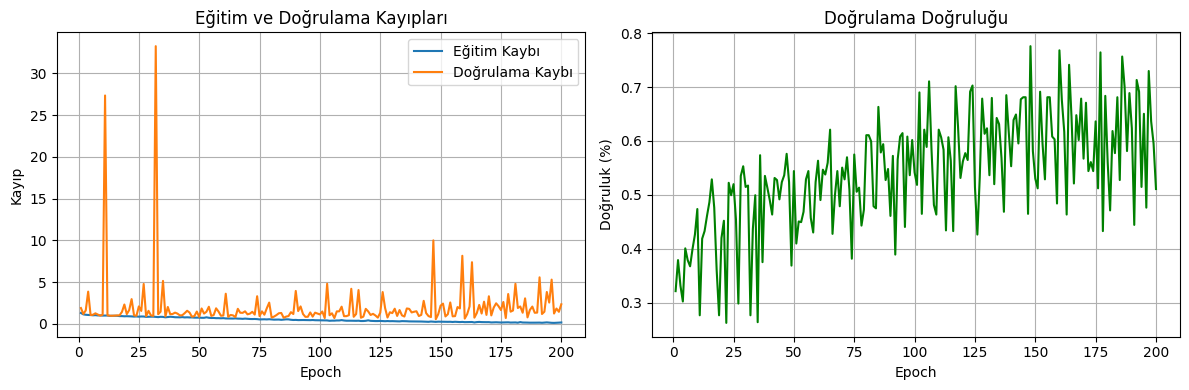

In [10]:
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Eğitim Kaybı')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.legend()
plt.grid(True)

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Doğrulama Doğruluğu', color='green')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.title('Doğrulama Doğruluğu')
plt.grid(True)

plt.tight_layout()
plt.show()

runs/BCI_CNN_kontrast_x_24
Test Doğruluğu: 79.43%
Test Doğruluğu 0: 50.00%
Test Doğruluğu 1: 65.53%
Test Doğruluğu 2: 87.22%
Test Doğruluğu 3: 82.95%


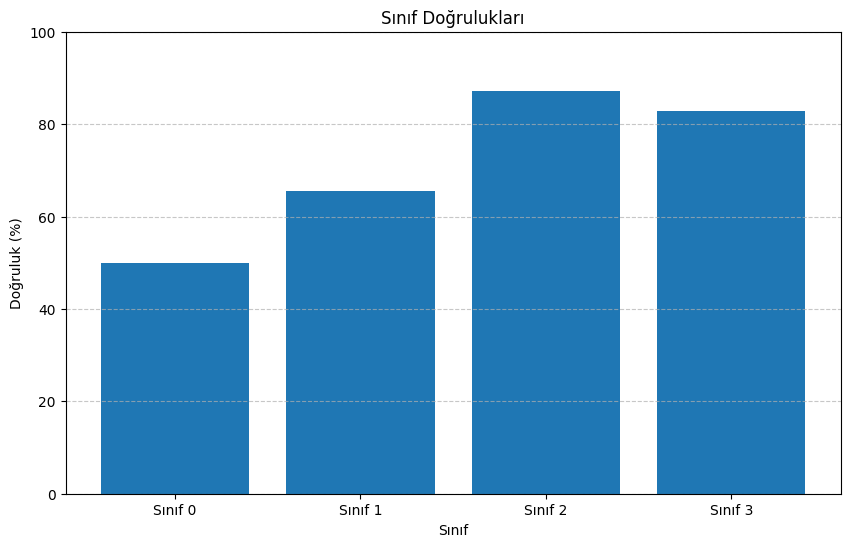

In [11]:
log_dir = f"runs/{experiment_name}_{experiment_num}"
print(log_dir)
best_model = BCI_Cnn()
best_model.load_state_dict(torch.load(f"{log_dir}/best_model{model_extension}"))
best_model.to(device)
best_model.eval()



correct = 0
total = 0

class_correct = [0] * 4
class_total = [0] * 4

with torch.no_grad():
    for images, labels in data_loader["test"]:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

acc = 100 * correct / total
print(f"Test Doğruluğu: {acc:.2f}%")
for i in range(4):
    class_acc = 100 * class_correct[i] / class_total[i]
    print(f"Test Doğruluğu {i}: {class_acc:.2f}%")

plt.figure(figsize=(10, 6))
class_acc = [100 * class_correct[i] / class_total[i] for i in range(4)]
plt.bar(range(4), class_acc)
plt.xlabel('Sınıf')
plt.ylabel('Doğruluk (%)')
plt.title('Sınıf Doğrulukları')
plt.xticks(range(4), [f"Sınıf {i}" for i in range(4)])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

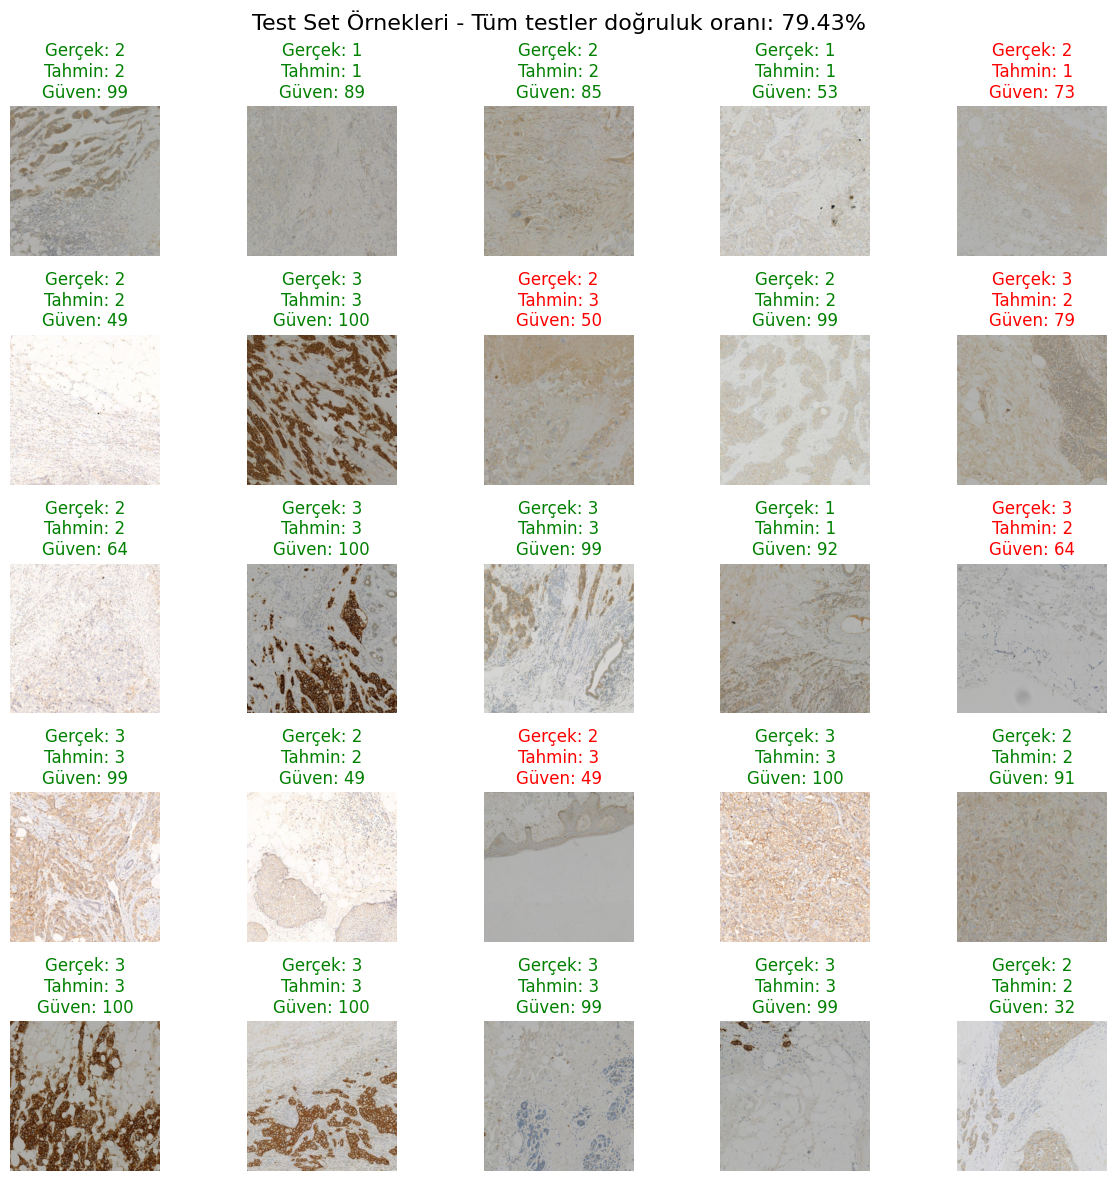

In [12]:
test_acc = 100 * correct / total
data_iter = iter(test_loader)
images, labels = next(data_iter)

indices = torch.randperm(len(images))[:25]
sample_images = images[indices].to(device)
sample_labels = labels[indices].to(device)

with torch.no_grad():
    outputs = best_model(sample_images)
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)


fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle(f"Test Set Örnekleri - Tüm testler doğruluk oranı: {test_acc:.2f}%", fontsize=16)
for i, ax in enumerate(axes.flat):
    img = sample_images[i].cpu().numpy().squeeze()
    color = "green" if preds[i] == sample_labels[i] else "red"
    ax.imshow(img.transpose(1, 2, 0))
    ax.set_title(
        f"Gerçek: {sample_labels[i].item()}\nTahmin: {preds[i].item()}\nGüven: {int(probs[i][preds[i]]*100)}",
        color=color,
    )
    ax.axis("off")



plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize variables to store true labels and predictions
all_labels = []
all_preds = []

# Collect predictions and true labels from the test set
with torch.no_grad():
    for images, labels in data_loader["test"]:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()